<a href="https://colab.research.google.com/github/VasantiP/fastai/blob/main/AI_for_Medical_Diagnosis_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore MRI Data and Labels Lab
Dataset is 3D MRI brain scans from the public [Medical Segmentation Decathlon](https://decathlon-10.grand-challenge.org/) challenge project.
It provides labels associated with each point (voxel) inside a 3D representation of a patient's brain.

In [ ]:
!pip install itk itkwidgets ipywidgets

In [ ]:
# Import all packages
# nibabel is for reading the data
# itk, itkwidgets, ipywidgets are for visualizing the data
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
image_path = '/content/images/BRATS_001.nii.gz'
image_obj = nib.load(image_path)
print(f'Type of the image {type(image_obj)}')

Type of the image <class 'nibabel.nifti1.Nifti1Image'>


In [ ]:
# Extract data as numpy ndarray
image_data = image_obj.get_fdata()
print(f'Type of the image data {type(image_data)}')
height, width, depth, channels = image_data.shape
print(f'Height: {height}, Width: {width}, Depth: {depth}, Channels: {channels}')

Type of the image data <class 'numpy.ndarray'>
Height: 240, Width: 240, Depth: 155, Channels: 4


Plotting Layer 151, Channel 3 of image


(np.float64(-0.5), np.float64(239.5), np.float64(239.5), np.float64(-0.5))

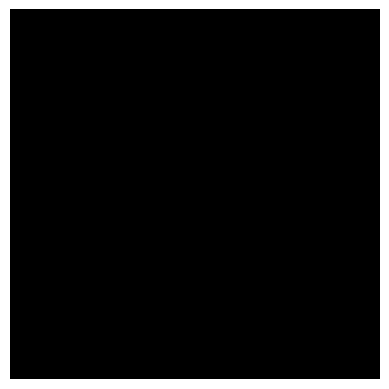

In [ ]:
# Select random layer number
maxval = depth - 1
layer_num = np.random.randint(maxval)
channel = 3
print(f'Plotting Layer {layer_num}, Channel {channel} of image')
plt.imshow(image_data[:, :, layer_num, channel], cmap='gray')
plt.axis('off')

In [ ]:
# Define a function to visualize the data
def explore_3dimage(layer):
  plt.figure(figsize=(10, 5))
  channel = 3
  plt.imshow(image_data[:, :, layer, channel], cmap='gray')
  plt.title('Explore Layers of Brain MRI', fontsize=20)
  plt.axis('off')
  return layer

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, image_data.shape[2] - 1))

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

<function __main__.explore_3dimage(layer)>

In [ ]:
# Load dataset containing the labels for the MRI
label_path = '/content/labels/BRATS_001.nii.gz'
label_obj = nib.load(label_path)
print(f'Type of the label {type(label_obj)}')

Type of the label <class 'nibabel.nifti1.Nifti1Image'>


In [ ]:
label_array = label_obj.get_fdata()
print(f'Type of the label array {type(label_array)}')
height, width, depth = label_array.shape
print(f'Height: {height}, Width: {width}, Depth: {depth}')
print(f'With unique values: {np.unique(label_array)}')
print("""Corresponding to the following label categories:
0: for normal
1: for edema
2: for non-enhancing tumor
3: for enhancing tumor""")

Type of the label array <class 'numpy.ndarray'>
Height: 240, Width: 240, Depth: 155
With unique values: [0. 1. 2. 3.]
Corresponding to the following label categories: 
0: for normal
1: for edema
2: for non-enhancing tumor
3: for enhancing tumor


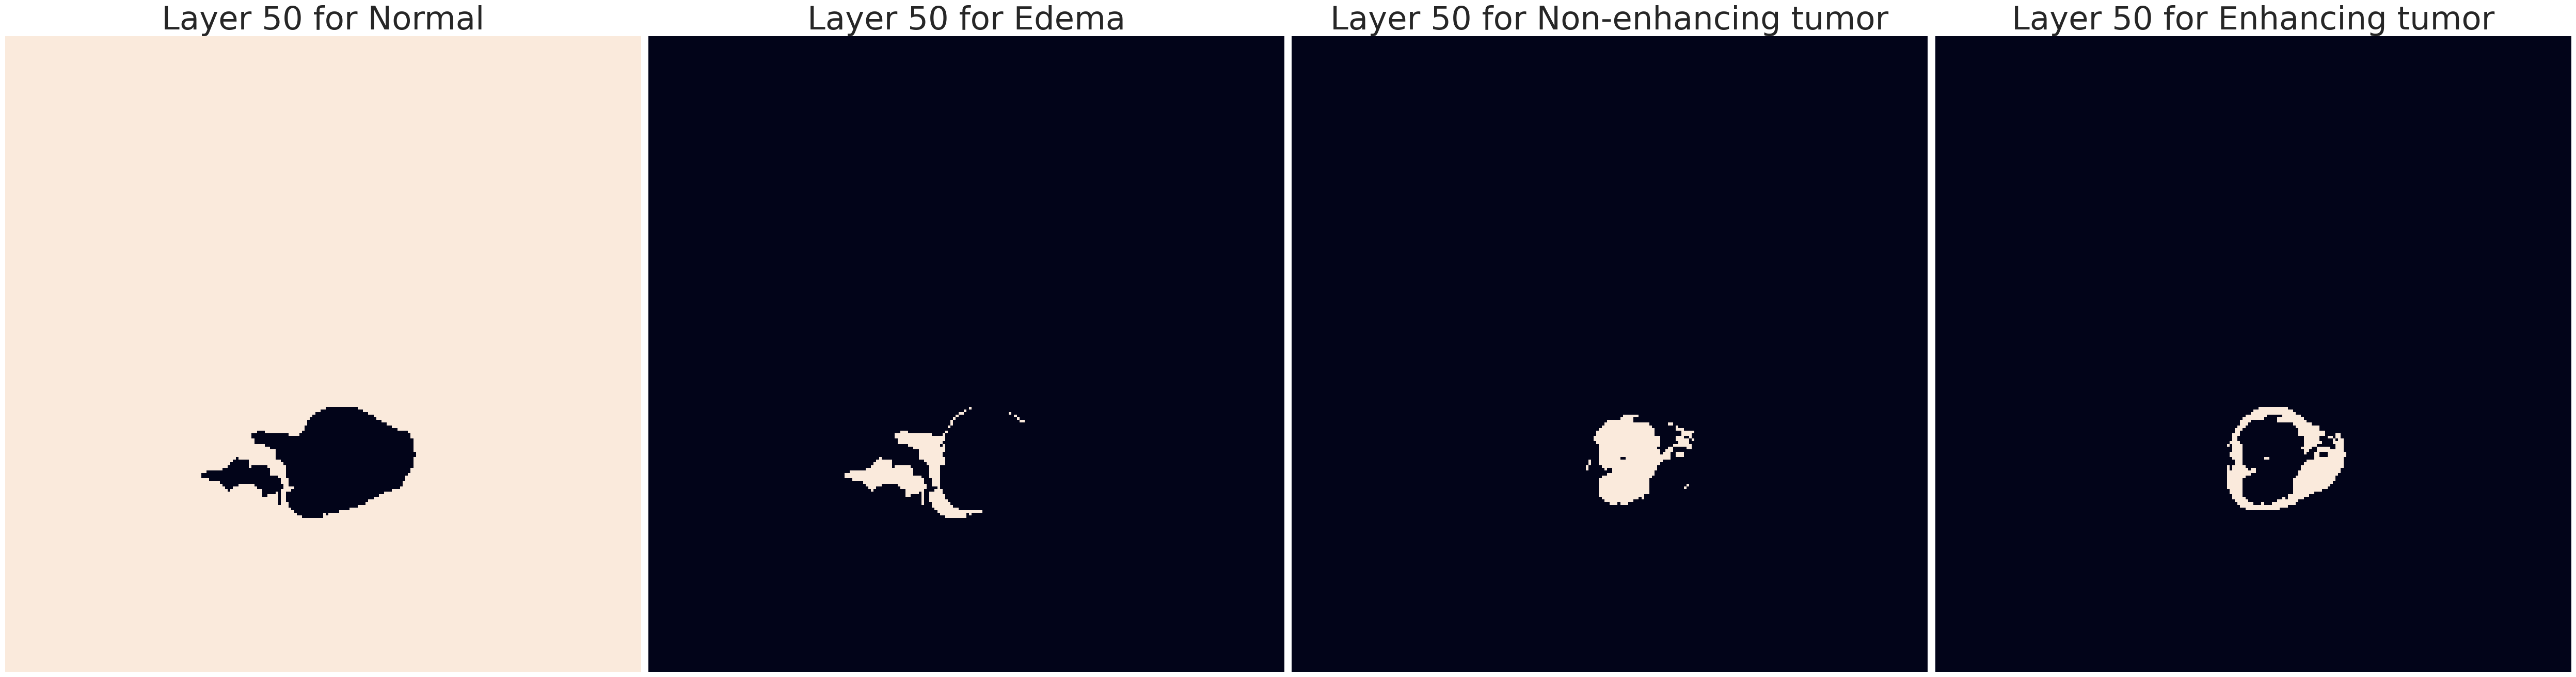

In [ ]:
from inspect import formatannotation
# Define a single layer for plotting
layer = 50
# Define a dictionary of class labels
classes_dict = {'Normal': 0., 'Edema': 1., 'Non-enhancing tumor': 2., 'Enhancing tumor': 3.}

#Setting up for plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50,30))
for i in range(4):
  img_label_str = list(classes_dict.keys())[i]
  img = label_array[:,:,layer] # 50th layer
  # apply mask: for values in layer that match the given label, set to 255 otherwise set to 0
  mask = np.where(img == classes_dict[img_label_str], 255, 0)
  ax[i].imshow(mask)
  ax[i].set_title(f'Layer {layer} for {img_label_str}', fontsize=45)
  ax[i].axis('off')
plt.tight_layout()


In [ ]:
# Interactive visualization
# Create button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info',

)
# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)


# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

# Image Registration
A challenge with MRI data is there can be multiple sequences taken of the same 3D model which need to be combined.  These are combined be representing them as different channels.  If one of the sequences is not aligned (eg. if the patient moved) then this can cause problems when combining the sequences.  
An approach to deal with this challenge is to perform **Image Registration**

# Segmentation
The process of defining the boundaries of objects (in this case various tissues) in an image.
Can also be thought of as defining the class of every point of an image

## Extracting a Sub Section Lab
Feeing in the entire MRI data volume into a model would be too memory intensive, so either have to pass in using *2D approach* of passing in by layers, or *3D approach* of passing in subsections (ie. small cubes)

In [ ]:
import numpy as np
import keras
import pandas as pd

In [ ]:
# Define a simple one dimensional "image" to extract from
image = np.array([10,11,12,13,14,15])
image_length = image.shape[0]

In [ ]:
patch_length = 3
start_i = 0
end_i = start_i + patch_length
print(f"start index: {start_i}, end index: {end_i}")

# Extract a sub-section from your "image"
sub_section = image[start_i:end_i]
print("output patch length: ", len(sub_section))
print("output patch array: ", sub_section)

# Add one to start index
start_i += 1

start index: 0, end index: 3
output patch length:  3
output patch array:  [10 11 12]


In [ ]:
valid_start_i = [i for i in range(image_length - patch_length + 1)]
print(valid_start_i)

[0, 1, 2, 3]


In [ ]:
# Randomly select multiple start indices in a loop
for _ in range(10):
  start_i = np.random.randint(image_length - patch_length + 1)
  print(f"randomly selected start index: {start_i}")

randomly selected start index: 0
randomly selected start index: 2
randomly selected start index: 3
randomly selected start index: 1
randomly selected start index: 0
randomly selected start index: 2
randomly selected start index: 2
randomly selected start index: 1
randomly selected start index: 3
randomly selected start index: 1


In [ ]:
# Background Ratio
# Need to compute ratio of background to edema
# 0: background
# 1: edema
# 2: non-enhancing tumor
# 3: enhancing tumor

# Generate random test data
patch_labels = np.random.randint(0, 4, (16))
print(patch_labels)

[1 0 0 2 0 3 0 2 1 3 0 1 3 2 2 3]


In [ ]:
bgrd_ratio = np.count_nonzero(patch_labels == 0) / len(patch_labels)
print(f"Using np.cound_nonzero: {bgrd_ratio}")

Using np.cound_nonzero: 0.3125


In [ ]:
# We'll use label array to train a neural network
# First convert the label's categories into one-hot format so it can be used to train the model
unique_patch_labels = np.unique(patch_labels)
print(unique_patch_labels)
patch_labels_one_hot = keras.utils.to_categorical(patch_labels, num_classes=len(unique_patch_labels))
print(patch_labels_one_hot)

[0 1 2 3]
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
pd.DataFrame(patch_labels_one_hot, columns=['background', 'edema', 'non-enhancing tumor', 'enhancing tumor'])

,background,edema,non-enhancing tumor,enhancing tumor
0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0
6,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,0.0,0.0,1.0


In [ ]:
# What we're interested in is the first column because that
# indicates if the element is part of the background
# In this case, 1 = background, 0 = non-background

print("background column: ", patch_labels_one_hot[:,0])

background column:  [0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
# we can compute the background ratio by counting the number of 1's
# in the said column divided by the length of the patch

bgrd_ratio = np.sum(patch_labels_one_hot[:,0])/ len(patch_labels)
print("using one-hot column: ", bgrd_ratio)

using one-hot column:  0.3125


# U-Net
U-Net is one of the most popular neural network architectures used for image segmentation for both the 2D task and 3D task  
The *depth* of the U-Net model is equal to the number of down-convolutions

More info on U-Net model:
- [U-Net Intro](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
- [U-Net original research paper](https://arxiv.org/pdf/1505.04597)
- [U-Net Wiki page](https://en.wikipedia.org/wiki/U-Net)

## Downward Path of U-Net
The left side of the U-Net is the downward path, and is contracting meaning the (height, width, length) of the input gets smaller as you move down this path, and the number of channels increases.

### Down-Convolution
For each depth and each layer within that depth the number of filters is specified.  
Formula for calculating the number of filters for layer 0:
$$filters_i=32 \times (2^i) $$ where $i$ is the current depth.
eg. for depth of first down convolution and first layer, i=0, $filters_0=32 \times (2^0) = 32$

Formula for calculating the number of filters for layer 1:
$$filters_i=32 \times (2^i) \times 2 $$ where $i$ is the current depth.  eg. for depth of first down convolution and second layer, i=0, $filters_0=32 \times (2^0) \times 2 = 64$

### Max Pooling
Within the U-Net architecture there is a max pooling operation after each down-convolution (excluding the last down-convolution at the bottom of the U, ie. $depth - 1$'th down-convolution)

## Upward Path of U-Net
The right side of the U-Net is the upward path, and is expanding, meaning image's (height, width, length) all get larger

### Up-Sampling
As input to the upsampling at the bottom of the U use the last layer of the downsampling

### Concatenation
Apply a concatenation operation using the layers that are both at the same depth of 0.  Both the layers must have the same height, width and length, if they are the same they can be concatenated along axis 1 (the channel axis)

### Up-convolution
The number of filters is set to the number of channels in the down-convolution's layer 1 at the same depth


# U-Net Model Lab
Creating a U-Net architecture with a depth of 2, and 2 convolutional layers for each depth


In [3]:
!pip install keras

In [4]:
# Imports
import keras
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization, PReLU, Conv3DTranspose
from keras.optimizers import Adam
from keras.layers import concatenate
# Set the image shape to have the channels in the first first dimension
K.set_image_data_format("channels_first")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [23]:
# Using U-Net with depth of 2
# Shape of input layer: (num_channels, height, width, length)
# num_channels: 4
# height: 160
# width: 160
# length: 16

input_layer = Input(shape=(4, 160, 160, 16))
input_layer

# The tensor shape that is returned has the dimensions: (batch_size, num_channels, height, width, height)

<KerasTensor shape=(None, 4, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>

In [24]:
# There are 2 convolutional layers for each depth
# Depth 0, Layer 0 has a 3D convolution and a ReLU activation
# Create the first 3D convolution
down_depth_0_layer_0 = Conv3D(filters=32,
                              kernel_size=(3,3,3),
                              padding='same',
                              strides=(1,1,1)
                              )(input_layer)
down_depth_0_layer_0

# the tensor shape that is returned has 32 channels because of the 32 filters

<KerasTensor shape=(None, 32, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_19>

In [25]:
# Add a relu activation to layer 0 of depth 0
down_depth_0_layer_0 = Activation('relu')(down_depth_0_layer_0)
down_depth_0_layer_0

<KerasTensor shape=(None, 32, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_20>

In [26]:
# Depth 0, Layer 1
down_depth_0_layer_1 = Conv3D(filters=64,
                              kernel_size=(3,3,3),
                              padding='same',
                              strides=(1,1,1)
                              )(down_depth_0_layer_0)
down_depth_0_layer_1 = Activation('relu')(down_depth_0_layer_1)
down_depth_0_layer_1

<KerasTensor shape=(None, 64, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_22>

In [27]:
# Define a max pooling layer
down_depth_0_layer_pool = MaxPooling3D(pool_size=(2,2,2))(down_depth_0_layer_1)
down_depth_0_layer_pool

<KerasTensor shape=(None, 64, 80, 80, 8), dtype=float32, sparse=False, ragged=False, name=keras_tensor_23>

In [28]:
# Depth 1, Layer 0
# number of filters for depth 1, layer 0: filters_1 = 32 x (2^1) = 64

# Add a Conv3D Layer with relu activiation
down_depth_1_layer_0 = Conv3D(filters=64,
                              kernel_size=(3,3,3),
                              padding='same',
                              strides=(1,1,1)
                              )(down_depth_0_layer_pool)
down_depth_1_layer_0 = Activation('relu')(down_depth_1_layer_0)
down_depth_1_layer_0

<KerasTensor shape=(None, 64, 80, 80, 8), dtype=float32, sparse=False, ragged=False, name=keras_tensor_25>

In [29]:
# Depth 1, Layer 1
# number of filters for depth 1, layer 1: filters_1 = 32 x (2^1) x 2 = 128

#Add a Conv3D Layer with relu activation
down_depth_1_layer_1 = Conv3D(filters=128,
                              kernel_size=(3,3,3),
                              padding='same',
                              strides=(1,1,1)
                              )(down_depth_1_layer_0)
down_depth_1_layer_1 = Activation('relu')(down_depth_1_layer_1)
down_depth_1_layer_1

<KerasTensor shape=(None, 128, 80, 80, 8), dtype=float32, sparse=False, ragged=False, name=keras_tensor_27>

In [30]:
# No max pooling at depth 1 (bottom of the U)

# Expanding (upward) Path
up_depth_0_layer_0 = UpSampling3D(size=(2,2,2))(down_depth_1_layer_1)
up_depth_0_layer_0

<KerasTensor shape=(None, 128, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_28>

In [31]:
# Concatenate upsampled depth 0 with downsampled depth 0
# up_depth_0_layer_0: shape is (None, 128, 160, 160, 16)
# down_depth_0_layer_1: shape is (None, 64, 160, 160, 16)
# double check both layers have the same height, width, and length.  Is (160, 160, 16) for both
# if they are the same they can be concatenated along the axis 1 (channel axis)

# Print shape of layers to concatenate
print(up_depth_0_layer_0)
print()
print(down_depth_0_layer_1)

<KerasTensor shape=(None, 128, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_28>

<KerasTensor shape=(None, 64, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_22>


In [32]:
# Add a concatenation along axis 1
up_depth_1_concat = concatenate([up_depth_0_layer_0, down_depth_0_layer_1], axis=1)
up_depth_1_concat

# In the upsampling layer the number of channels is a concatenation of channels from the upsampling layer and down-convolution layer
# eg. 128 + 64 = 192 channels

<KerasTensor shape=(None, 192, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_29>

In [33]:
# Up-convolution Depth 0, Layer 1
# Get number of filters from down_depth_0_layer_1 number of channels
print(f"number of filters: {down_depth_0_layer_1._shape[1]}")

number of filters: 64


In [34]:
# Depth 1, layer 1
# Add a Conv3D up-convolution with 64 filters to your network
up_depth_1_layer_1 = Conv3D(filters=64,
                            kernel_size=(3,3,3),
                            padding='same',
                            strides=(1,1,1)
                            )(up_depth_1_concat)
up_depth_1_layer_1 = Activation('relu')(up_depth_1_layer_1)
up_depth_1_layer_1

<KerasTensor shape=(None, 64, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_31>

In [35]:
# Up-convolution Depth 0, Layer 2
# the up-convolution number of filters for layer 2 will again equal the number of filters
# from the down-convolution depth 0 layer 1
print(down_depth_0_layer_1)
print(f"number of filters: {down_depth_0_layer_1._shape[1]}")

<KerasTensor shape=(None, 64, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_22>
number of filters: 64


In [36]:
# Add a Conv3D up-convolution
up_depth_1_layer_2 = Conv3D(filters=64,
                            kernel_size=(3,3,3),
                            padding='same',
                            strides=(1,1,1)
                            )(up_depth_1_layer_1)
up_depth_1_layer_2 = Activation('relu')(up_depth_1_layer_2)
up_depth_1_layer_2


<KerasTensor shape=(None, 64, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_33>

In [37]:
# For the final convolution, set the number of filters to be equal to the number of classes in your input
# There are 3 classes:
# 1: edema
# 2: non-enhancing tumor
# 3: enhancing tumor

# Add final Conv3D with 3 filters
final_conv = Conv3D(filters=3, #3 categories
                    kernel_size=(1,1,1),
                    padding='valid',
                    strides=(1,1,1)
                    )(up_depth_1_layer_2)
final_conv

<KerasTensor shape=(None, 3, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_34>

In [38]:
# Add a sigmoid activation to the final convolution
final_activation = Activation('sigmoid')(final_conv)
final_activation

<KerasTensor shape=(None, 3, 160, 160, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_35>

In [39]:
# Create and compile the model
model = Model(inputs=input_layer, outputs=final_activation)
model.compile(optimizer=Adam(0.00001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [40]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 4, 160,    │          0 │ -                 │
│ (InputLayer)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 32, 160,   │      3,488 │ input_layer_1[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 32, 160,   │          0 │ conv3d_7[0][0]    │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 64, 160,   │     55,360 │ activation_7[0][… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 64, 160,   │          0 │ conv3d_8[0][0]    │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 64, 80,    │          0 │ activation_8[0][… │
│ (MaxPooling3D)      │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 64, 80,    │    110,656 │ max_pooling3d_1[… │
│                     │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 64, 80,    │          0 │ conv3d_9[0][0]    │
│ (Activation)        │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_10 (Conv3D)  │ (None, 128, 80,   │    221,312 │ activation_9[0][… │
│                     │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128, 80,   │          0 │ conv3d_10[0][0]   │
│ (Activation)        │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_1     │ (None, 128, 160,  │          0 │ activation_10[0]… │
│ (UpSampling3D)      │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192, 160,  │          0 │ up_sampling3d_1[… │
│ (Concatenate)       │ 160, 16)          │            │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_11 (Conv3D)  │ (None, 64, 160,   │    331,840 │ concatenate_1[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 64, 160,   │          0 │ conv3d_11[0][0]   │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_12 (Conv3D)  │ (None, 64, 160,   │    110,656 │ activation_11[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 160,   │          0 │ conv3d_12[0][0]   │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_13 (Conv3D)  │ (None, 3, 160,    │        195 │ activation_12[0]

 Total params: 833,507 (3.18 MB)

 Trainable params: 833,507 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Function to create the entire U-Net Model:
# Some code was borrowed from:
# https://github.com/ellisdg/3DUnetCNN/blob/master/unet3d/


def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)


def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Deconvolution3D(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

def unet_model_3d(loss_function, input_shape=(4, 160, 160, 16),
                  pool_size=(2, 2, 2), n_labels=3,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=4, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
    """
    Builds the 3D UNet Keras model.f
    :param metrics: List metrics to be calculated during model training (default is dice coefficient).
    :param include_label_wise_dice_coefficients: If True and n_labels is greater than 1, model will report the dice
    coefficient for each label as metric.
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=
                                            current_layer._shape[1])(
            current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1]._shape[1],
            input_layer=concat, batch_normalization=batch_normalization)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1]._shape[1],
            input_layer=current_layer,
            batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model

In [46]:
model_2 = unet_model_3d(depth=2,
                        loss_function='categorical_crossentropy',
                        metrics=['categorical_accuracy'])
model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 4, 160,    │          0 │ -                 │
│ (InputLayer)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 32, 160,   │      3,488 │ input_layer_4[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 32, 160,   │          0 │ conv3d_25[0][0]   │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 64, 160,   │     55,360 │ activation_25[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 64, 160,   │          0 │ conv3d_26[0][0]   │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 80,    │          0 │ activation_26[0]… │
│ (MaxPooling3D)      │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_27 (Conv3D)  │ (None, 64, 80,    │    110,656 │ max_pooling3d_4[… │
│                     │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 64, 80,    │          0 │ conv3d_27[0][0]   │
│ (Activation)        │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_28 (Conv3D)  │ (None, 128, 80,   │    221,312 │ activation_27[0]… │
│                     │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 128, 80,   │          0 │ conv3d_28[0][0]   │
│ (Activation)        │ 80, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_3     │ (None, 128, 160,  │          0 │ activation_28[0]… │
│ (UpSampling3D)      │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 192, 160,  │          0 │ up_sampling3d_3[… │
│ (Concatenate)       │ 160, 16)          │            │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_29 (Conv3D)  │ (None, 64, 160,   │    331,840 │ concatenate_3[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 64, 160,   │          0 │ conv3d_29[0][0]   │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_30 (Conv3D)  │ (None, 64, 160,   │    110,656 │ activation_29[0]… │
│                     │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 64, 160,   │          0 │ conv3d_30[0][0]   │
│ (Activation)        │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_31 (Conv3D)  │ (None, 3, 160,    │        195 │ activation_30[0]

 Total params: 833,507 (3.18 MB)

 Trainable params: 833,507 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

# Data Augmentation for Image Segmenation
Data Augmentation can be applied to Image Segmentation tasks, with few key differences:
- Because image segmenation has an segmentation output, any transformation applied to input (eg. 90 degree rotation) needs to be applied to the output too
- Transformation needs to apply to whole 3D volume
- In loss function want to be able to specify the error

# Loss Function for Image Segmentation
**Soft Dice Loss** will measure the error between our prediction map, P, and our ground truth map, G.  It is a popular loss function for segmentation models, having the advantage that it works well for imbalanced data.
P and G are represented as a table with each row of the table is a cell location, along with the corresponding prediction and ground truth value.
$$L(P,G)=1-\text{overlap between P and G}$$
$$L(P,G)=1-\frac{2\sum_i^n p_ig_i}{\sum_i^n p_i^2 + \sum_i^n g_i^2}$$
We want the overlap fraction to be large, such that a high overlap corresponds to a small loss, and a small overlap corresponds to a high loss


In [2]:
import numpy as np
p = np.array([0.3, 0.7, 0.3, 0.7, 0.9, 0.7, 0.3, 0.7, 0.3])
g = np.array([0, 1, 0, 1 ,1 , 1, 0, 1 ,0])
pg = p*g
overlap = 2*np.sum(pg)/(np.sum(p**2)+np.sum(g**2))
loss = 1-overlap

In [4]:
p2 = np.array([0.5, 0.7, 0.5, 0.7, 0.9, 0.7, 0.5, 0.7, 0.5])
pg2 = p2*g
overlap2 = 2*np.sum(pg2)/(np.sum(p2**2)+np.sum(g**2))
loss2 = 1-overlap2

In [5]:
(loss, loss2)

(np.float64(0.0897908979089791), np.float64(0.1562143671607754))

# External Validation
External Validation is the practice of validating a model on a test set that is not drawn from the same dataset as the training and validation data sets.
If external validation results are poor, it is possible to split the external dataset into training, validation and test data and fine tune the existing model with this.

One reason an external dataset might not work well is it real-world data, vs the cleaned data of the training data.  This is one challenge with using models for clinical diagnosis in the real world.

# Measuring Patient Outcomes
Another challenge of using models for clinical diagnosis in the real world is ability to measure their effectiveness. Two approaches:
- Decision Curve Analysis
- Randomized Controlled Trials

Want to analyse the effect on total population as well as subgroups of the population. (eg. across age, sex, socioeconomic status) in order to identify any biases in the model

# Brain Tumor Auto-Segmentation for MRI Assignment
The MR images are in the DICOM Format.  The DICOM format is the output format for most commercial MRI scanners.  It can be processed using the pydicom Python libary.

In this assignment, we will be using the data from the [Decathlon 10 Challenge](https://decathlon-10.grand-challenge.org/). This data has been mostly pre-processed for the competition participants, however in real practice, MRI data needs to be significantly pre-preprocessed before we can use it to train our models.

- `keras` framework for building deep learning models
- `keras.backend` library for math operations on tensors
- `nibabel` library to extract the images and labels from the files in the dataset
- `numpy` library for mathematical and scientific operation
- `pandas` library for maniuplating data

In [1]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)